In [ ]:
from satellite import Satellite
import pandas as pd

In [ ]:
s = Satellite()
stats = pd.read_csv('Atlanta_supply_dat.xlsx - Atlanta_dat.csv') # PREDICT NEXT 4 QUARTERS
buildings = pd.read_csv('Atlanta_supply_dat.xlsx - UC_buildings.csv') # ALL

In [ ]:
samp = buildings.sample(3)

In [ ]:
samp.iloc[0]['Address']

'3520 us 287   Decatur, TX 76234'

In [12]:
imgMax, imgMin, metadata = s.bing_pipeline(samp.iloc[0]['Address'], "BirdseyeV2")

IndexError: list index out of range

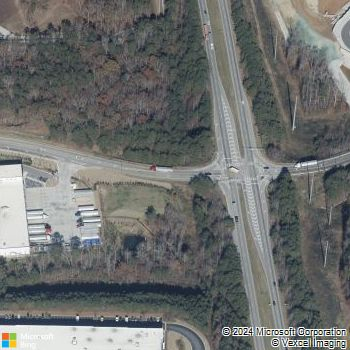

In [8]:
imgMin

In [9]:
metadata

{'authenticationResultCode': 'ValidCredentials',
 'brandLogoUri': 'https://dev.virtualearth.net/Branding/logo_powered_by.png',
 'copyright': 'Copyright © 2024 Microsoft and its suppliers. All rights reserved. This API cannot be accessed and the content and any results may not be used, reproduced or transmitted in any manner without express written permission from Microsoft Corporation.',
 'resourceSets': [{'estimatedTotal': 1,
   'resources': [{'__type': 'BirdseyeMetadata:http://schemas.microsoft.com/search/local/ws/rest/v1',
     'imageHeight': 512,
     'imageUrl': None,
     'imageUrlSubdomains': None,
     'imageWidth': 512,
     'imageryProviders': None,
     'vintageEnd': '08 Dec 2020 GMT',
     'vintageStart': '08 Dec 2020 GMT',
     'zoomMax': 22,
     'zoomMin': 18,
     'orientation': 0,
     'tilesX': 28,
     'tilesY': 21}]}],
 'statusCode': 200,
 'statusDescription': 'OK',
 'traceId': '56edc8f14deb5b5d74bf47fbf0b60e81|BN00006C65|0.0.0.1'}